# Conditional Generation
Let's train a diffusion model that use some information like a label or a prompt to generate a specific type of image.

We will use a dataset that have different categories and give both, image and label to the model on training.

The Fashion MNIST is the dataset we will use. 

In [15]:
import torch
import diffusers

from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt

In [3]:
fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]

### A little fnct to show easily images

In [62]:
def show_images(images_tensor:torch.tensor, cmap = "grey"):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap);
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap);

In [61]:
def show_images_list(images_list:list[torch.Tensor], cmap = "grey") -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    show_images(images_tensor.unsqueeze(1),cmap)

[9, 0, 0, 3, 0, 2, 7, 2]


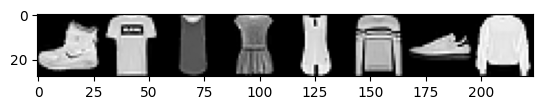

In [6]:
toTensor = transforms.ToTensor()

clothes_tensor = [ toTensor(img) for img in clothes]

show_images_list(clothes_tensor)
print(classes)

## Preparing the dataset

In [26]:
preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),  #Random Flip (Data augmentation)
    transforms.ToTensor(),              #To Torch Tensor
    transforms.Pad(2),                  # Add a padding of 2 pixels
    transforms.Normalize([0.5], [0.5])  # Normalize to (-1,1)
])

def dataset_preprocess(examples):
    images = [preprocess(example) for example in examples["image"]]
    return {"images": images,"labels":examples["label"]}

preprocesed_dataset = fashion_mnist["train"].with_transform(dataset_preprocess)

train = torch.utils.data.DataLoader(
    dataset=preprocesed_dataset,
    shuffle=True,
    batch_size=256
)

test = torch.utils.data.DataLoader(
    dataset=fashion_mnist["test"].with_transform(dataset_preprocess),
    shuffle=True,
    batch_size=256
)


## Unet
We can use the same Unet, and give the argument 'num_classes_embeds' to indicate will use 10 different classes

In [ ]:
model = diffusers.UNet2DModel(
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1,
    sample_size=32,
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10,  # Enable class conditioning
).cuda()

In [48]:
x = torch.rand((1,1,32,32)).cuda()

with torch.inference_mode():
    out = model(x,timestep=7, class_labels = torch.tensor([2]).cuda() ).sample

out.shape

torch.Size([1, 1, 32, 32])

## Training the model

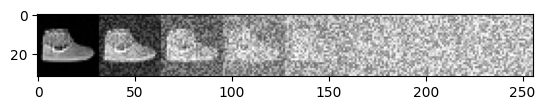

In [24]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train))

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [25]:
from torch.nn import functional as F
n_epochs = 25
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, eps=1e-5)
loss_fn = F.mse_loss
losses = []

In [31]:
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: diffusers.schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    # losses_list = []

    for nlote,x in enumerate(loader):
        classes = x["labels"].cuda()
        x       = x["images"].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, class_labels=classes, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [32]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: diffusers.schedulers, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            classes = x["labels"].cuda()
            x       = x["images"].cuda()
            
            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, class_labels=classes, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


In [33]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(test,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")

Iteración: 1 / 25 -----------------------------
Nº de lote:	 0
Loss:			 1.3404972553253174

Nº de lote:	 10
Loss:			 0.18608736991882324

Nº de lote:	 20
Loss:			 0.16046187281608582

Nº de lote:	 30
Loss:			 0.10551412403583527

Nº de lote:	 40
Loss:			 0.10075895488262177

Nº de lote:	 50
Loss:			 0.0888793021440506

Nº de lote:	 60
Loss:			 0.08768807351589203

Nº de lote:	 70
Loss:			 0.06543733179569244

Nº de lote:	 80
Loss:			 0.06300344318151474

Nº de lote:	 90
Loss:			 0.07584656774997711

Nº de lote:	 100
Loss:			 0.06720434874296188

Nº de lote:	 110
Loss:			 0.05954177305102348

Nº de lote:	 120
Loss:			 0.05899661034345627

Nº de lote:	 130
Loss:			 0.056710727512836456

Nº de lote:	 140
Loss:			 0.05179354548454285

Nº de lote:	 150
Loss:			 0.047221407294273376

Nº de lote:	 160
Loss:			 0.044572614133358

Nº de lote:	 170
Loss:			 0.04557881876826286

Nº de lote:	 180
Loss:			 0.04870421066880226

Nº de lote:	 190
Loss:			 0.04630047827959061

Nº de lote:	 200
Loss:			

In [34]:
torch.save(model.state_dict(),"Fashion_mnist_firt.pth")

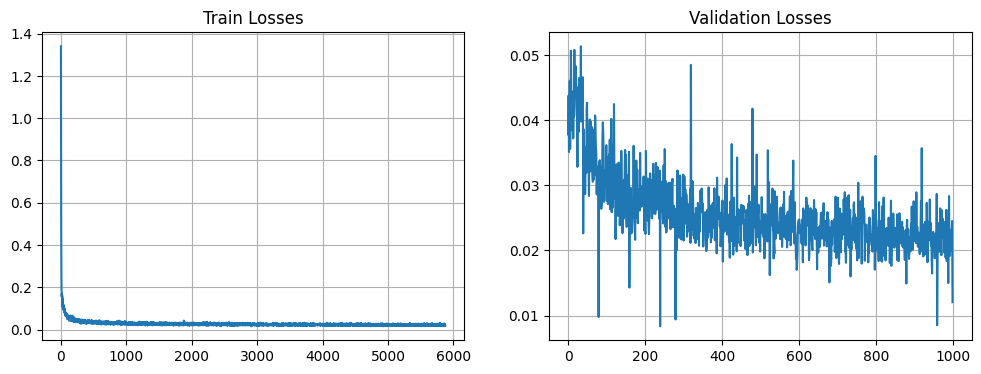

In [35]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

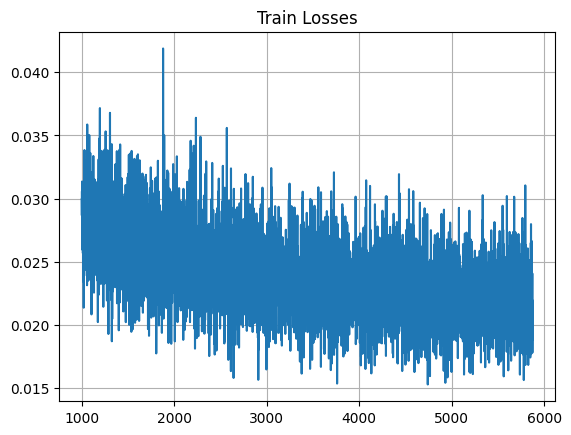

In [37]:
plt.title("Train Losses")
plt.plot(range(1000,len(train_loss)),train_loss[1000:]);
plt.grid()

## Sampling
After the training, we can use iterative denoising to generate new images. We have to pass the class we want to generate.

In [ ]:
def generate_from_class(class_to_generate, n_samples:int =8):
    sample = torch.randn(n_samples, 1, 32, 32).cuda()
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).cuda()

    model.eval()

    for _,t in enumerate(scheduler.timesteps):
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels).sample

        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1,1) * 0.5 + 0.5

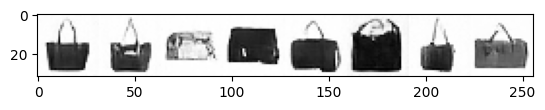

In [65]:
images =  generate_from_class(8)
show_images(images.cpu(), cmap="grey_r")